<a href="https://colab.research.google.com/github/milosbozic/ml-conference-workshop/blob/master/ml_conferece_wokshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

To activate GPU device, go to **Runtime** -> **Change runtime type**  and in popup window under **Hardware accelerator** drop menu select GPU device and save.  
To check is GPU device avaible, run code below.

In [142]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Check what they gave us for free :)

In [143]:
! nvidia-smi

Thu May 16 13:56:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |    405MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Data 

## Load and clean data

Data set which we will use is [Individual household electric power consumption Data Set](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption) .  
We have to get data and we can download our dataset and unzip it using a couple of bash commands:

In [144]:
! mkdir data && wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip && unzip household_power_consumption.zip -d data/

mkdir: cannot create directory ‘data’: File exists


Check is file downloaded and unziped. List folder content:

In [145]:
! ls data/
! head data/household_power_consumption.txt

household_power_consumption.txt
Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000
16/12/2006;17:25:00;5.360;0.436;233.630;23.000;0.000;1.000;16.000
16/12/2006;17:26:00;5.374;0.498;233.290;23.000;0.000;2.000;17.000
16/12/2006;17:27:00;5.388;0.502;233.740;23.000;0.000;1.000;17.000
16/12/2006;17:28:00;3.666;0.528;235.680;15.800;0.000;1.000;17.000
16/12/2006;17:29:00;3.520;0.522;235.020;15.000;0.000;2.000;17.000
16/12/2006;17:30:00;3.702;0.520;235.090;15.800;0.000;1.000;17.000
16/12/2006;17:31:00;3.700;0.520;235.220;15.800;0.000;1.000;17.000
16/12/2006;17:32:00;3.668;0.510;233.990;15.800;0.000;1.000;17.000


When we have out data set local we can import it using pandas. 

In [146]:
import pandas as pd

data = pd.read_csv('data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
#print(data.head())
heder = list(data)
print(heder)
print(data.shape)


['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
(2075259, 7)


Now let's check is there any non numeric or missing values  and how many.

In [147]:
print(data.isnull().sum())

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64


On this way we can only check are Nan values in data frame, but because we didn't set NaN values string array in read_csv method, initialy we can only catch default NaN strings like "nan", "Nan", but not others strings like "?" or "-"

In [148]:
#data.apply(pd.to_numeric)
missing_values = ["?"]
data = pd.read_csv('data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'], na_values = missing_values)
data = data.astype('float32')
print(data.isnull().sum())

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


When we find all missing values and mark them as NaN, let's fill them somehow.

In [149]:
import numpy as np

def fill_NaN(values, hist):
  one_day = 60 * 24
  for row in range(values.shape[0]):
    for col in range(values.shape[1]):
      if np.isnan(values[row, col]):
        hist_values = []
        for k in range(1, hist+1):
          hist_values.append(values[row - one_day*k, col])
        values[row, col] = np.array(hist_values).mean()
 
# fill missing
fill_NaN(data.values, 2)

# Check again is there missing values
print(data.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


## Prepare data for modeling

In [150]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0


Our data is power consumption measured per minute frequency, but we are more interested in hourly or daily values. Because of that we have to resample data to get daily values and we can use pandas [***resample()***](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) function with appropriate argument to do it.

In [151]:
data_daily = data.resample('D').mean()
#data_daily.apply(pd.to_numeric)
data_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243759,13.082829,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087021,9.999028,1.411806,2.907639,9.264584
2006-12-18,1.530435,0.112356,241.231689,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308060,6.467361,0.000000,1.838889,9.765972


Let's plot original data and our resampled data.

Text(0.5, 1.0, 'Daily resampled data')

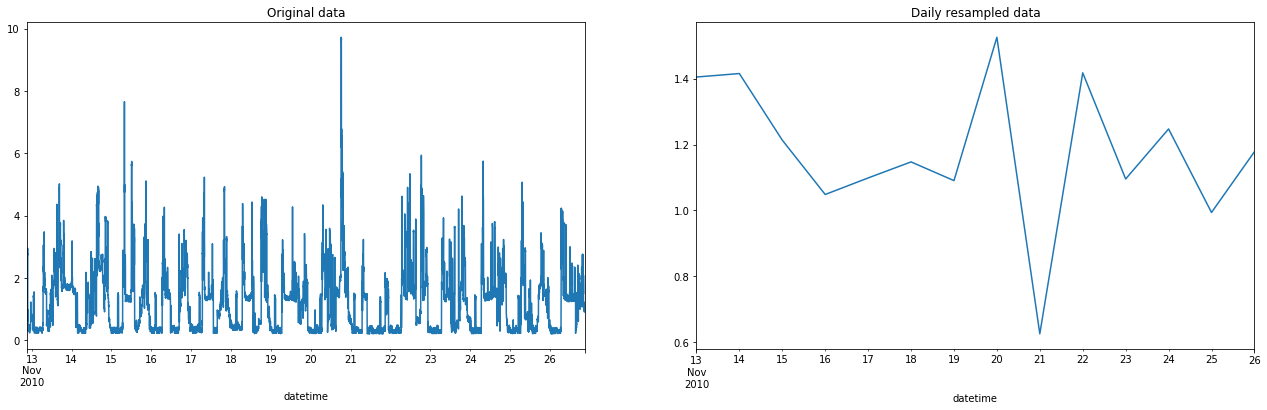

In [152]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
data['Global_active_power'].tail(14*60*24).plot(ax=axes[0], subplots=True, x='time', y='active_power', legend=False)
axes[0].set_title('Original data')
data_daily['Global_active_power'].tail(14).plot(ax=axes[1], subplots=True, x='time', y='active_power', legend=False)
axes[1].set_title('Daily resampled data')

Split resampled data to train and test subsets.

In [153]:
data_daily.tail()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-22,1.417733,0.098857,240.197113,6.014167,3.371528,1.465278,7.038889
2010-11-23,1.095511,0.095451,240.575531,4.674445,1.299306,0.318056,5.285417
2010-11-24,1.247394,0.091986,240.030960,5.249583,0.761111,1.977778,8.488889
2010-11-25,0.993864,0.080644,241.536255,4.169445,0.747222,0.295833,3.522222
2010-11-26,1.178230,0.095666,240.291031,4.956295,0.855107,0.304830,7.908947


In [154]:
train_start = '2006-12-16'
train_end =   '2010-10-31'
test_start = '2010-10-25'     #'2010-11-01'
test_end = '2010-11-26'

train_mask = pd.date_range(train_start, train_end, freq='D')
test_mask = pd.date_range(test_start, test_end, freq='D')
#print(train_mask)
#print(test_mask)

train = data_daily.loc[train_mask]
test = data_daily.loc[test_mask]

train.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2010-10-27,0.875193,0.106828,246.108704,3.622917,0.000000,1.429167,5.742361
2010-10-28,1.016199,0.130028,246.253891,4.200139,0.765972,1.824306,6.310417
2010-10-29,0.836404,0.135917,245.743103,3.511945,0.746528,0.504167,2.715972
2010-10-30,1.494931,0.135639,243.267365,6.229028,1.634028,0.426389,10.627084
2010-10-31,1.025299,0.144501,245.495285,4.235139,0.993056,0.470833,3.881250


In [155]:
test.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2010-10-25,0.807842,0.110644,242.406158,3.392222,0.000000,0.375694,4.686111
2010-10-26,0.656878,0.120324,244.890961,2.750417,0.000000,1.727778,3.464583
2010-10-27,0.875193,0.106828,246.108704,3.622917,0.000000,1.429167,5.742361
2010-10-28,1.016199,0.130028,246.253891,4.200139,0.765972,1.824306,6.310417
2010-10-29,0.836404,0.135917,245.743103,3.511945,0.746528,0.504167,2.715972


# Modeling

## Sequences sampling

An LSTM model expects input data to have the shape:  [samples, timesteps, features]  

###Univariate sequences 

**Univariate with one or multi-steps time series**

In [0]:
# univariate sequence to input samples
def univariate_split(sequence, timesteps, horizon):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + timesteps
    out_end_ix = end_ix + horizon
    #check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

Let's test our function.

In [157]:
# make simple test sequence
in_seq = np.arange(0, 200, 10)
#print(raw_seq)

# set a number of input time steps
n_steps = 7
# set a number of prediction steps
n_out = 1

# split into samples
X, y = univariate_split(in_seq, n_steps, n_out)

# print
for i in range(len(X)):
	print(X[i], y[i])

print(X.shape, y.shape)

[ 0 10 20 30 40 50 60] [70]
[10 20 30 40 50 60 70] [80]
[20 30 40 50 60 70 80] [90]
[30 40 50 60 70 80 90] [100]
[ 40  50  60  70  80  90 100] [110]
[ 50  60  70  80  90 100 110] [120]
[ 60  70  80  90 100 110 120] [130]
[ 70  80  90 100 110 120 130] [140]
[ 80  90 100 110 120 130 140] [150]
[ 90 100 110 120 130 140 150] [160]
[100 110 120 130 140 150 160] [170]
[110 120 130 140 150 160 170] [180]
[120 130 140 150 160 170 180] [190]
(13, 7) (13, 1)


### Multivariate sequences

* **Multiple input with one or multi-step output time series**

In [0]:
# multivariate sequence into samples
def multivariate_split(sequences, timesteps, horizon):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + timesteps
    out_end_ix = end_ix + horizon #- 1
    # check if we are beyond the dataset
    if out_end_ix > len(sequences):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

Test function

In [159]:
in_seq1 = np.arange(0, 100, 10)
in_seq2 = np.arange(5, 100, 10)
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

#print(dataset)

# set a number of time steps
n_steps = 7
n_out = 1

# split into samples
X, y = multivariate_split(dataset, n_steps, n_out)

# print
for i in range(len(X)):
	print(X[i], y[i])

print(X.shape, y.shape)

[[ 0  5]
 [10 15]
 [20 25]
 [30 35]
 [40 45]
 [50 55]
 [60 65]] [145]
[[10 15]
 [20 25]
 [30 35]
 [40 45]
 [50 55]
 [60 65]
 [70 75]] [165]
[[20 25]
 [30 35]
 [40 45]
 [50 55]
 [60 65]
 [70 75]
 [80 85]] [185]
(3, 7, 2) (3, 1)


* **Multiple parallel with one or multi-step output time series** 

In [0]:
def multivariate_parallel_split(sequences, timesteps, horizon):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + timesteps
    out_end_ix = end_ix + horizon
		# check if we are beyond the dataset
    if out_end_ix > len(sequences)-1:
      break
		# gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

Test function

In [161]:
in_seq1 = np.arange(0, 100, 10)
in_seq2 = np.arange(5, 100, 10)
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

#print(dataset)

# set a number of time steps
n_steps = 3
n_out = 2

X, y = multivariate_parallel_split(dataset, n_steps, n_out)

for i in range(len(X)):
	print(X[i], y[i])

[[ 0  5  5]
 [10 15 25]
 [20 25 45]] [[30 35 65]
 [40 45 85]]
[[10 15 25]
 [20 25 45]
 [30 35 65]] [[ 40  45  85]
 [ 50  55 105]]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [[ 50  55 105]
 [ 60  65 125]]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [[ 60  65 125]
 [ 70  75 145]]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [[ 70  75 145]
 [ 80  85 165]]


## Build LSTM models

### Univariate sequences

Make input sequence for model, let's predict active power consumption.

In [0]:
seq = train['Global_active_power'].values

timesteps = 7
horizon = 1

X, y = univariate_split(seq, timesteps, horizon)

# reshape from [samples, timesteps] -> [samples, timesteps, features]
n_features = 1

X = X.reshape((X.shape[0], X.shape[1], n_features))


#### Build  and train the simple (vanilla) LSTM model

In [163]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(200, activation='relu', input_shape=(timesteps, n_features)),
    #tf.keras.layers.Dense(100, activation='relu'),  # Additional dense layer helps
    tf.keras.layers.Dense(1)
])

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

model.fit(X, y, epochs=100, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


Test model

(26, 1)


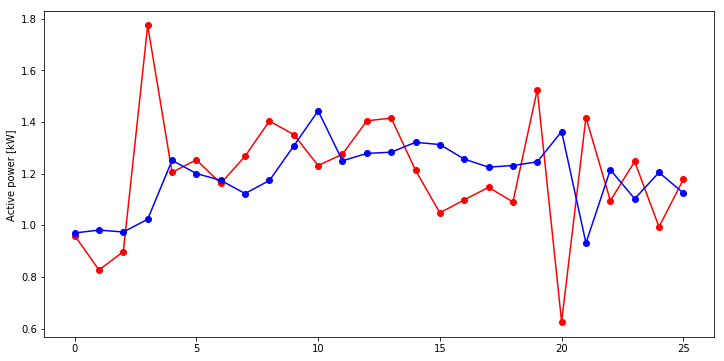

MAE = 0.18462461233139038
MSE = 0.07030914723873138
MAPE = 16.7446106672287


In [164]:
test_seq = test['Global_active_power'].values
# We are doing prediction one step ahead and we can generate test sequence using same function as we used for traing sequence 
x_test, y_test = univariate_split(test_seq, timesteps, horizon)

y_real = y_test
print(y_real.shape)

x_test = x_test.reshape((x_test.shape[0], timesteps, n_features))
yhat = model.predict(x_test, verbose=0)

plt.figure(figsize=(12,6))
plt.plot(y_real, 'r', marker='o')
plt.plot(yhat, 'b', marker='o')
plt.ylabel('Active power [kW] ')
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAPE implementation
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calc errors
print('MAE = {}'.format(mean_absolute_error(y_real, yhat)))
print('MSE = {}'.format(mean_squared_error(y_real, yhat)))
print('MAPE = {}'.format(MAPE(y_real, yhat)))

#### Build and train stacked LSTM model

In [165]:
model_s = tf.keras.Sequential([
    tf.keras.layers.LSTM(200, activation='relu', return_sequences=True, input_shape=(timesteps, n_features)),
    tf.keras.layers.LSTM(200, activation='relu', input_shape=(timesteps, n_features)),
    #tf.keras.layers.Dense(100, activation='relu'), # Additinal danse layer doesn't help
    tf.keras.layers.Dense(1)
])

model_s.summary()

model_s.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

model_s.fit(X, y, epochs=100, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 7, 200)            161600    
_________________________________________________________________
lstm_16 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________


Test stacked LSTM model

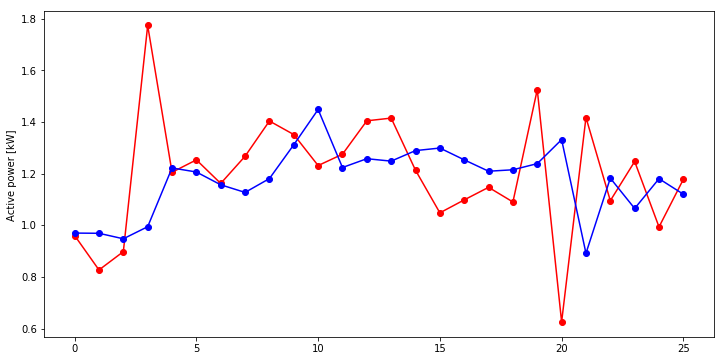

MAE = 0.18222250044345856
MSE = 0.07126063853502274
MAPE = 16.281388700008392


In [166]:
test_seq = test['Global_active_power'].values

x_test, y_test = univariate_split(test_seq, timesteps, horizon)

x_test = x_test.reshape((x_test.shape[0], timesteps, n_features))
yhat = model_s.predict(x_test, verbose=0)

plt.figure(figsize=(12,6))
plt.plot(y_real, 'r', marker='o')
plt.plot(yhat, 'b', marker='o')
plt.ylabel('Active power [kW] ')
plt.show()

# Calc errors
print('MAE = {}'.format(mean_absolute_error(y_real, yhat)))
print('MSE = {}'.format(mean_squared_error(y_real, yhat)))
print('MAPE = {}'.format(MAPE(y_real, yhat)))

#### Recursive prediction 

Let's define recursive prediction function,
where inputs will be input vector and prediction horizont
  


In [0]:
def recursive_prediction(model, input_x, horizon = 1):
  pred = list()
  for i in range(horizon):
    input_x = input_x.reshape(1,input_x.shape[0], 1)
    y_pred = model.predict(input_x, verbose=0)
    pred.append(y_pred.flatten())
    a = input_x[0][1:].flatten()
    b = y_pred.flatten()
    input_x = np.concatenate((a, b), axis=0)
  
  return np.array(pred)


Do recusive prediction on all test set, this means with horizon 26 ie. predict for 26 days ahead.

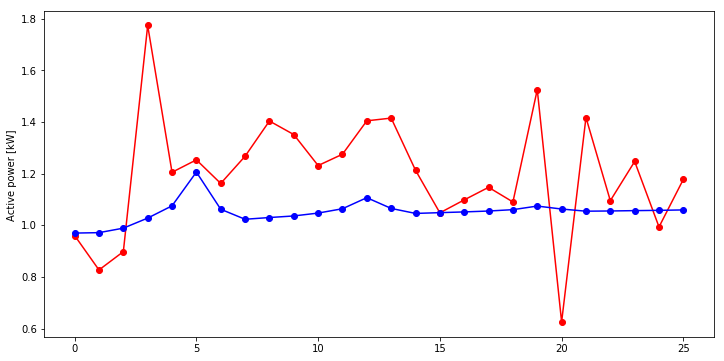

MAE = 0.20176856219768524
MSE = 0.07023239880800247
MAPE = 16.531507670879364


In [169]:
pred = recursive_prediction(model_s, x_test[0], horizon = 26)

# Plot results and calc prediction metrics
plt.figure(figsize=(12,6))
plt.plot(y_real, 'r', marker='o')
plt.plot(pred, 'b', marker='o')
plt.ylabel('Active power [kW] ')
plt.show()

# Calc errors
print('MAE = {}'.format(mean_absolute_error(y_real, pred)))
print('MSE = {}'.format(mean_squared_error(y_real, pred)))
print('MAPE = {}'.format(MAPE(y_real, pred)))

Let's try to do recursive prediction but with smaller horizont in few steps to cover all test set, for example 7 which means we will do prediction for 7 day ahead.

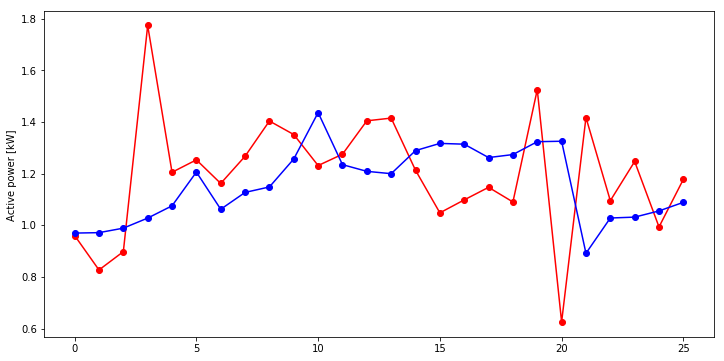

MAE = 0.1975821554660797
MSE = 0.07230301946401596
MAPE = 19.00612711906433


In [174]:
horizon = 7
results = []

for k in range(0, len(x_test), horizon):
  x_input = x_test[k]
  pred = recursive_prediction(model_s, x_input, horizon)
  
  results.append(pred.flatten())

pred = np.array(results).flatten()[:26]
  
# Plot results and calc prediction metrics
plt.figure(figsize=(12,6))
plt.plot(y_real, 'r', marker='o')
plt.plot(pred, 'b', marker='o')
plt.ylabel('Active power [kW] ')
plt.show()

# Calc errors
print('MAE = {}'.format(mean_absolute_error(y_real, pred)))
print('MSE = {}'.format(mean_squared_error(y_real, pred)))
print('MAPE = {}'.format(MAPE(y_real, pred)))



### Multivariate sequence

Let's predict active power using voltage and current intesity.

In [0]:
in_seq1 = train['Voltage'].values
in_seq2 = train['Global_intensity'].values
out_seq = train['Global_active_power'].values

in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stacked sequences
dataset = np.hstack((in_seq1, in_seq2, out_seq))
#print(dataset)

timesteps = 7
horizon = 1

X, y = multivariate_split(dataset, timesteps, horizon)
#print(X[0], y[0])

n_features = 2


Build and train model

In [176]:
model_m = tf.keras.Sequential([
    tf.keras.layers.LSTM(200, activation='relu', return_sequences=True, input_shape=(timesteps, n_features)),
    tf.keras.layers.LSTM(200, activation='relu', input_shape=(timesteps, n_features)),
    tf.keras.layers.Dense(100, activation='relu'), # Additinal danse layer helps
    tf.keras.layers.Dense(1)
])

model_m.summary()

model_m.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

model_m.fit(X, y, epochs=100, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 200)            162400    
_________________________________________________________________
lstm_18 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 503,401
Trainable params: 503,401
Non-trainable params: 0
_________________________________________________________________


Test model

(1416, 3)
(26, 7, 2) (26, 1)


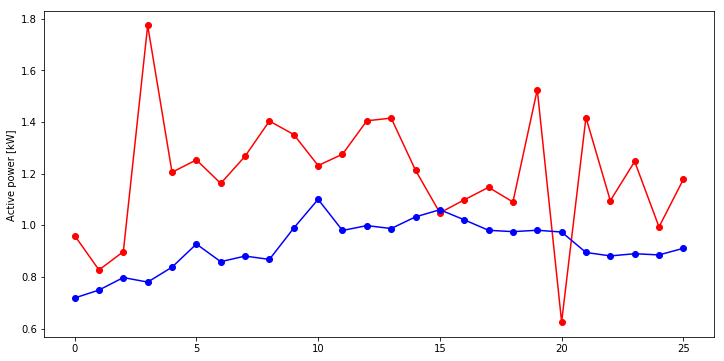

MAE = 0.30273106694221497
MSE = 0.1325039267539978
MAPE = 24.267390370368958


In [177]:
in_test_seq1 = test['Voltage'].values
in_test_seq2 = test['Global_intensity'].values
out_test_seq = test['Global_active_power'].values

in_test_seq1 = in_test_seq1.reshape((len(in_test_seq1), 1))
in_test_seq2 = in_test_seq2.reshape((len(in_test_seq2), 1))
out_test_seq = out_test_seq.reshape((len(out_test_seq), 1))

#print(in_test_seq1.shape)
#print(out_test_seq.shape)


# horizontally stacked sequences
dataset_test = np.hstack((in_test_seq1, in_test_seq2, out_test_seq))
print(dataset.shape)

x_test, y_test = multivariate_split(dataset_test, timesteps, horizon)
print(x_test.shape, y_test.shape)

yhat = model_m.predict(x_test, verbose=0)

plt.figure(figsize=(12, 6))
plt.plot(y_real, 'r', marker='o')
plt.plot(yhat, 'b', marker='o')
plt.ylabel('Active power [kW] ')
plt.show()

# Calc errors
print('MAE = {}'.format(mean_absolute_error(y_real, yhat)))
print('MSE = {}'.format(mean_squared_error(y_real, yhat)))
print('MAPE = {}'.format(MAPE(y_real, yhat)))

### Multi-step univariate model

Let's make input sequence with for multi-step model

In [178]:
%reset_selective -f seq, X, y

seq = train['Global_active_power'].values

timesteps = 7
horizon = 7

X, y = univariate_split(seq, timesteps, horizon)

# reshape from [samples, timesteps] -> [samples, timesteps, features]
n_features = 1

X = X.reshape((X.shape[0], X.shape[1], n_features))

print(X.shape, y.shape)

(1403, 7, 1) (1403, 7)


Build and train stacked LSTM multi-step model

In [179]:
model_multi_stacked = tf.keras.Sequential([
    tf.keras.layers.LSTM(200, activation='relu', return_sequences=True, input_shape=(timesteps, n_features)),
    tf.keras.layers.LSTM(200, activation='relu', input_shape=(timesteps, n_features)),
    #tf.keras.layers.Dense(100, activation='relu'), # Additinal danse layer doesn't help
    tf.keras.layers.Dense(horizon)
])

model_multi_stacked.summary()

model_multi_stacked.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

model_multi_stacked.fit(X, y, epochs=100, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 7, 200)            161600    
_________________________________________________________________
lstm_20 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 1407      
Total params: 483,807
Trainable params: 483,807
Non-trainable params: 0
_________________________________________________________________


Test model

In [192]:
%reset_selective -f pred, x_test, results

test_seq = test['Global_active_power'].values
print(test_seq.shape)

x_test, y_test = univariate_split(test_seq, timesteps, horizon)
x_test = x_test.reshape((x_test.shape[0], timesteps, n_features))

results = []

for k in range(0, len(x_test), horizon):
  x_input = x_test[k]
  
  pred = model_multi_stacked.predict(x_test, verbose=0)
  
  results.append(pred.flatten())

pred = np.array(results).flatten()[:26]


print(x_test.shape)
print(pred.shape)


(33,)
(20, 7, 1)
(26,)


Calc metrics and plot results

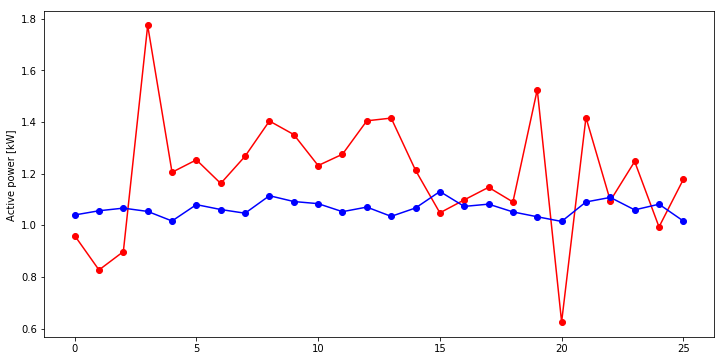

MAE = 0.21279391646385193
MSE = 0.0698125958442688
MAPE = 17.77673363685608


In [193]:
plt.figure(figsize=(12, 6))
plt.plot(y_real, 'r', marker='o')
plt.plot(pred, 'b', marker='o')
plt.ylabel('Active power [kW] ')
plt.show()

# Calc errors
print('MAE = {}'.format(mean_absolute_error(y_real, pred)))
print('MSE = {}'.format(mean_squared_error(y_real, pred)))
print('MAPE = {}'.format(MAPE(y_real, pred)))

#### Model time-series with feed forward neural net

In [0]:
%reset_selective -f X, y, yhat, x_test

seq = train['Global_active_power'].values

timesteps = 7
horizon = 1

X, y = univariate_split(seq, timesteps, horizon)

n_features = 1

Build and train NN model

In [205]:
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(200, activation='relu', input_dim=timesteps),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_nn.summary()

model_nn.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

model_nn.fit(X, y, epochs=100, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               1600      
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 201       
Total params: 42,001
Trainable params: 42,001
Non-trainable params: 0
_________________________________________________________________


Test model, predict one step ahead

(33,)


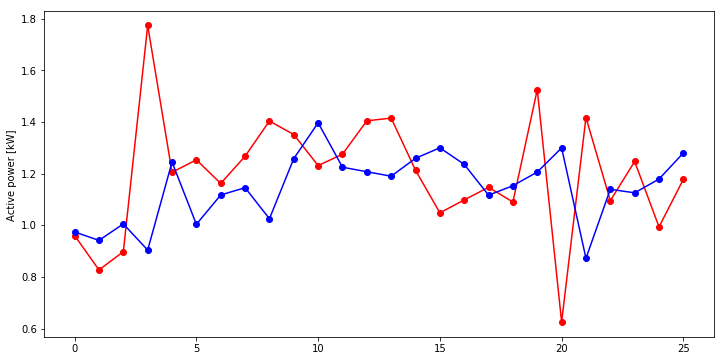

MAE = 0.19974711537361145
MSE = 0.08229047805070877
MAPE = 17.354680597782135


In [206]:
test_seq = test['Global_active_power'].values
print(test_seq.shape)

x_test, y_test = univariate_split(test_seq, timesteps, horizon)

yhat = model_nn.predict(x_test, verbose=0)


plt.figure(figsize=(12, 6))
plt.plot(y_real, 'r', marker='o')
plt.plot(yhat, 'b', marker='o')
plt.ylabel('Active power [kW] ')
plt.show()

# Calc errors
print('MAE = {}'.format(mean_absolute_error(y_real, yhat)))
print('MSE = {}'.format(mean_squared_error(y_real, yhat)))
print('MAPE = {}'.format(MAPE(y_real, yhat)))

Let's do recursive prediction for 7 steps ahead.

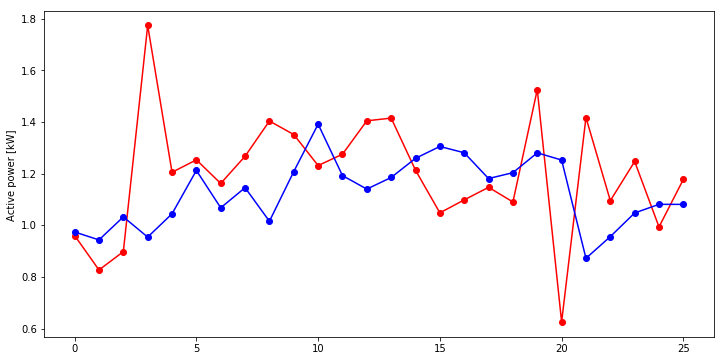

MAE = 0.2056269496679306
MSE = 0.0778813511133194
MAPE = 18.72524917125702


In [227]:
# Recursive prediciton function for classic NN, model has different input shape (1, timesteps)
def nn_recursive_prediction(model, input_x, horizon = 1):
  pred = list()
  for i in range(horizon):
    input_x = input_x.reshape(1, input_x.shape[0])
    y_pred = model.predict(input_x, verbose=0)
    pred.append(y_pred.flatten())
    a = input_x[0][1:].flatten()
    b = y_pred.flatten()
    input_x = np.concatenate((a, b), axis=0)
  
  return np.array(pred)

horizon = 7
results = []

for k in range(0, len(x_test), horizon):
  
  x_input = x_test[k]
  pred = nn_recursive_prediction(model_nn, x_input, horizon)
  
  results.append(pred.flatten())

pred = np.array(results).flatten()[:26]
  
# Plot results and calc prediction metrics
plt.figure(figsize=(12, 6))
plt.plot(y_real, 'r', marker='o')
plt.plot(pred, 'b', marker='o')
plt.ylabel('Active power [kW] ')
plt.show()

# Calc errors
print('MAE = {}'.format(mean_absolute_error(y_real, pred)))
print('MSE = {}'.format(mean_squared_error(y_real, pred)))
print('MAPE = {}'.format(MAPE(y_real, pred)))

